# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, starting from a provided template a CNN-classifier of traffic sign images has been built. The so-called GTSRB (The German Traffic Sign Recognition Benchmark) [dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news) contains labeled data of traffic sign images. We used a pre-processed version of the dataset, where the images are already scaled up to dimensions of 32x32. 

The high-level overview of the project:
1. [Dataset exploration](#data_exploration)
2. [Pre-processing and augmentation of the data](#preprocessing)
3. [Building a Convolutional Neural Network (Lenet-like architecture)](#architecture)
4. [Training, validataion and testing the network using Tensorflow and the augmented dataset](#training)
5. [Testing network on new images from the Internet (traffic signs found on google street view)](#new_images)

---
## Step 0: Load The Data

The training, validation, and test data are provided by Udacity as pickle files. We start with downloading and reading the provided datasets.

In [12]:
# Load pickled data
import pickle
import urllib.request
import zipfile
import os

data_set_zip_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip"
file_name = './traffic-signs-data-new.zip'

if not os.path.isfile(file_name):
    print("Downloading dataset from the web...")
    # download the dataset from the Web
    urllib.request.urlretrieve(data_set_zip_url, file_name)
    print("Extracting the archive...")
    # extract pickle files from the zip archive
    zip_ref = zipfile.ZipFile(file_name, 'r') 
    zip_ref.extractall('./')
    zip_ref.close()
    print("Done..")
else:
    print("Dataset was downloaded before, openning pickle files")

#pickle files
training_file = 'train.p'
validation_file = 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

#numpy arrays of training, validation and test sets
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

Dataset was downloaded before, openning pickle files


---

## <a id='data_exploration'>Step 1: Dataset Summary & Exploration</a>

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [15]:
# Number of training examples
n_train = X_train.shape[0] # 34799 

# Number of validation examples
n_validation = X_valid.shape[0] # 4410

# Number of testing examples.
n_test = X_test.shape[0] # 12630

# The shape of an traffic sign image: all the images are pre-processed to be of an equal size
image_shape = X_train.shape[1:] # 32x32x3 -- RGB image of 32x32 px

# Unique classes/labels in the dataset.
n_classes = len(set(y_train)) # 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of the dataset

We plot:
1. a random image for each class
2. some random images of a random class (to see deviations of images for particular class)
3. histogram of examples distribution per class for training, validation, and test data

In [13]:
import numpy as np
import random
#create a 1-D human interpretable array of tuples of image classes
text_labels = np.recfromcsv('./signnames.csv', delimiter=',')
_, text_labels = zip(*text_labels)
#decode byte strings from labels
text_labels = list(map(lambda x : x.decode("utf-8"), text_labels))

In [14]:
### Data exploration visualization code goes here.
import matplotlib.pyplot as plt
import math
# Visualizations will be shown in the notebook.
%matplotlib inline

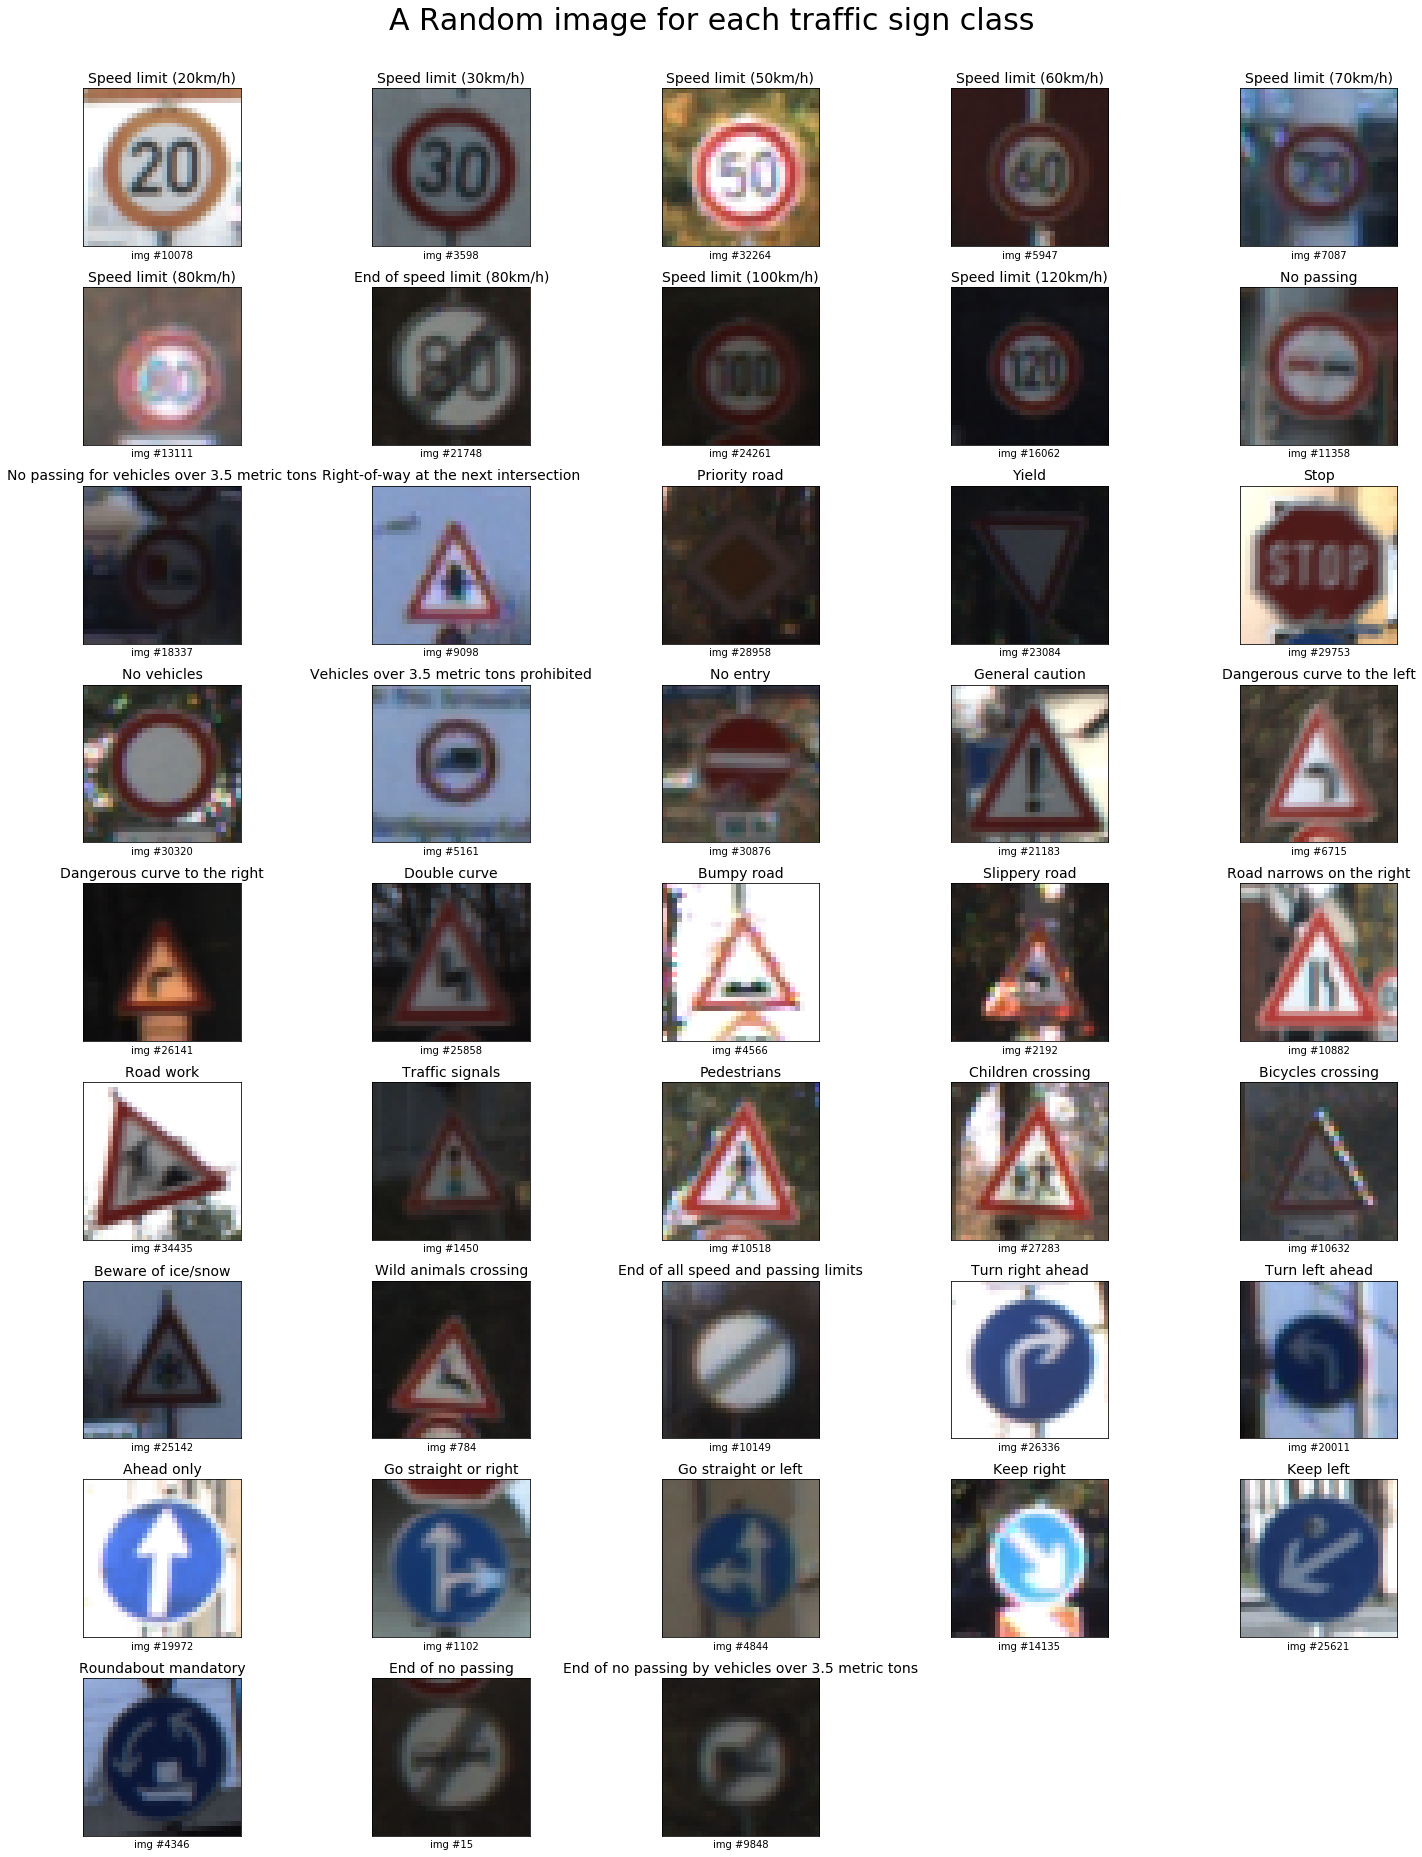

In [48]:
#print 1 random image of every class of traffic signs
NUM_COLUMNS = 5
NUM_ROWS = math.ceil(n_classes / NUM_COLUMNS)
fig = plt.figure(figsize=(20,25))
for label in range(n_classes):
    idx = random.choice(list(np.where(y_train == label)[0]))
    img = X_train[idx]
    ax = fig.add_subplot(NUM_ROWS,NUM_COLUMNS,label+1)
    ax.imshow(img, interpolation='none')
    ax.set_title(text_labels[label],  fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("img #{}".format(idx))
plt.tight_layout(w_pad=-0.5, h_pad=+1.0)
plt.suptitle('A Random image for each traffic sign class', y=1.03, fontsize=30)
plt.show()

In [ ]:
#randomly print `num_images` of one random class
random_class = random.choice(range(n_classes))
num_images = 24
NUM_COLUMNS = 6
NUM_ROWS = math.ceil(num_images / NUM_COLUMNS)
images = np.random.choice(list(np.where(y_train == random_class)[0]), num_images, replace=False)
fig = plt.figure(figsize=(6,6))
for idx, el in enumerate(images):
    img = X_train[el]
    ax = fig.add_subplot(NUM_ROWS,NUM_COLUMNS,idx+1)
    ax.imshow(img, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle("Random images of \"{}\" traffic sign".format(text_labels[random_class]), y=0.85)
fig.tight_layout(w_pad=0.2, h_pad=-11.0)
plt.show()

In [ ]:
#print histograms of image classes in the data set
fig = plt.figure(figsize=(10,14))
ax = fig.add_subplot(111)
(n_train, bins_train, _) = plt.hist(y_train, 3*len(set(y_train)), histtype='bar', 
                                    align='mid', alpha=0.3, orientation='horizontal',
                                    label='training')
(n_test, bins_test, _) = plt.hist(y_test, 3*len(set(y_test)), histtype='bar', 
                                  align='mid', color='green', orientation='horizontal', alpha=0.5,
                                  label='test')
(n_valid, bins_valid, _) = plt.hist(y_valid, 3*len(set(y_valid)), histtype='bar', 
                                    align='mid',color='red', orientation='horizontal', alpha=0.7,
                                   label='validation')
plt.legend(bbox_to_anchor=(1.0,0.85))
ax.set_yticks(list(range(n_classes)))
ax.set_ylim([-1, n_classes])
ax.set_yticklabels(text_labels)
ax.set_xticks(list(range(0,2600,200)))
plt.gca().invert_yaxis()
ax.xaxis.tick_top()
plt.show()

---
## <a id='preprocessing'>Step 2: Pre-process the Data Set (image filters and normalization)</a>

As some image classes are less represented then others (seen from the histogram above), we use algorithms for image processing from `skimage.exposure` and `skimage.transform` to augment image classes with filtered images. Namely, methods for histogram equalization, non-linear transforms and small rotation (7 degrees). We define filters which map images to images, namely ``filter : image -> image'``. Note, that all the methods of `skimage.exposure` map image pixels to `[0,1]` domain.

In [23]:
import skimage.exposure 
import skimage.transform

#filter functions for data augmentation
from functools import partial

def filter_eqhist(img):
    return skimage.exposure.equalize_hist(img)

def filter_eqadapthist(img):
    return skimage.exposure.equalize_adapthist(img, 17, 0.4)

def filter_adjustlog(img):
    return skimage.exposure.adjust_log(filter_eqadapthist(img), 0.8)

def filter_adjustsigmoid(img):
    return skimage.exposure.adjust_sigmoid(filter_eqadapthist(img), cutoff=0.4, gain=8)

def filter_rotate(img, func, angle):
    return skimage.transform.rotate(func(img), angle)
 
#rotated images of the filter functions
filter_eqadapthistright = partial(filter_rotate, func=filter_eqadapthist, angle=random.randint(4,9))
filter_eqadapthistleft = partial(filter_rotate, func=filter_eqadapthist, angle=random.randint(-9,-4))
filter_eqhistright = partial(filter_rotate, func=filter_eqadapthist, angle=random.randint(4,9))
filter_eqhistleft = partial(filter_rotate, func=filter_eqadapthist, angle=random.randint(-9,-4))
filter_adjustlogright = partial(filter_rotate, func=filter_adjustlog, angle=random.randint(4,9))
filter_adjustlogleft = partial(filter_rotate, func=filter_adjustlog, angle=random.randint(-9,-4))
filter_adjustsigmoidright = partial(filter_rotate, func=filter_adjustsigmoid, angle=random.randint(4,9))
filter_adjustsigmoidleft = partial(filter_rotate, func=filter_adjustsigmoid, angle=random.randint(-9,-4))

A function that returns an image filter

In [ ]:
def create_filter(filter_num):
    filters = [filter_eqhist,
               filter_eqadapthist,
               filter_adjustlog,
               filter_adjustsigmoid,
               filter_eqadapthistright,
               filter_eqadapthistleft,
               filter_eqhistright,
               filter_eqhistleft,
               filter_adjustlogright,
               filter_adjustlogleft,
               filter_adjustsigmoidright,
               filter_adjustsigmoidleft]
    return filters[filter_num % len(filters)]

In [ ]:
# Showcase filter functions
# Apply filters on a random image
fig = plt.figure(figsize=(16,3))

NUM_IMG = 13
img_idx = 1
ax = fig.add_subplot(1,NUM_IMG,img_idx)
pic_raw = random.choice(X_train)
plt.imshow(pic_raw)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Original', fontsize=9)

for idx in range(12):
    ax = fig.add_subplot(1,NUM_IMG,idx+2)
    img_filter = create_filter(idx)
    pic = img_filter(pic_raw)
    plt.imshow(pic)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Filter {}".format(idx+1), fontsize=9)
    
plt.show()

Exploring underrepresented image classes: print (image classes, #examples) in ascending order of training examples:

In [ ]:
#traffic sign classes in ascending order of image examples 
from collections import OrderedDict
n_train_ = list(filter(lambda x : x > 0, n_train))
n_train_dict = {idx: el for idx,el in enumerate(n_train_)}
X_train_summary = OrderedDict(sorted(n_train_dict.items(), key=lambda t: t[1]))
print(X_train_summary)

We now extend the dataset with newly generated images. Essentally, we apply filters on images of underrepresented classes and put the results in the augmented dataset. Pseudo code below gives an idea how we extend the training set.

The implementation of the pseudo-code is as follows:

In [ ]:
def find_ids_of_img_class(dataset, img_class):
    return list(np.where(dataset == img_class)[0])

threshold = 1900
X_augmented = []
Y_augmented = []
for class_id, num_examples in X_train_summary.items():
    if num_examples < threshold:
        print("Augmenting dataset for traffic sign class '{}', of '{}' elements".format(class_id, num_examples))
        img_ids = find_ids_of_img_class(y_train, class_id)
        num_filter = 0
        X_augmented_partial = []
        y_augmented_partial = []
        examples_total = num_examples
        while examples_total < threshold :
            img_filter = create_filter(num_filter)
            X_augmented_partial = list(map(lambda x: img_filter(x), X_train[img_ids]))
            Y_augmented_partial = [class_id] * len(X_augmented_partial)
            examples_total += len(X_augmented_partial)
            X_augmented += X_augmented_partial
            Y_augmented += Y_augmented_partial
            num_filter += 1
        print("New training dataset: {} images, {} labels".format(len(X_augmented),len(Y_augmented)))
print("Done..")
X_augmented_np = np.array(X_augmented)
Y_augmented_np = np.array(Y_augmented)


Images in the augmented dataset are already scaled to `[0,1]`, we do the same for original training, validation, and test data. We then subtract `0.5` to ensure zero mean.

In [ ]:
#concatenate augmented and original dataset
#normalize the data
X_train = X_train / 255
X_train_new = np.concatenate((X_train, X_augmented_np), axis=0) - 0.5
Y_train_new = np.concatenate((y_train, Y_augmented_np), axis=0)

X_valid_new = X_valid / 255 - 0.5
Y_valid_new = y_valid

X_test_new = X_test / 255 - 0.5
Y_test_new = y_test

Histogram of the augmented training set:

In [ ]:
#print histograms of image classes in the data set
fig = plt.figure(figsize=(10,14))
ax = fig.add_subplot(111)
(n_train, bins_train, _) = plt.hist(Y_train_new, 3*len(set(Y_train_new)), histtype='bar', 
                                    align='mid', alpha=0.3, orientation='horizontal',
                                    label='training')
(n_test, bins_test, _) = plt.hist(y_test, 3*len(set(y_test)), histtype='bar', 
                                  align='mid', color='green', orientation='horizontal', alpha=0.5,
                                  label='test')
(n_valid, bins_valid, _) = plt.hist(y_valid, 3*len(set(y_valid)), histtype='bar', 
                                    align='mid',color='red', orientation='horizontal', alpha=0.7,
                                   label='validation')
plt.legend(bbox_to_anchor=(1.0,0.85))
ax.set_yticks(list(range(n_classes)))
ax.set_ylim([-1, n_classes])
ax.set_yticklabels(text_labels)
ax.set_xticks(list(range(0,2600,200)))
plt.gca().invert_yaxis()
ax.xaxis.tick_top()
plt.show()

In [ ]:
# save augmented training set
# experienced MemoryError when trying to use pickle
# use dill instead: X_train_new is 2.3G, pretty large file

import dill
if not os.path.isfile("./X_train_new.p"):
    dill.dump(X_train_new, open("X_train_new.p", "wb"))
    dill.dump(Y_train_new, open("Y_train_new.p", "wb"))
    dill.dump(X_valid_new, open("X_valid_new.p", "wb"))
    dill.dump(Y_valid_new, open("Y_valid_new.p", "wb"))
    dill.dump(X_test_new, open("X_test_new.p", "wb"))
    dill.dump(Y_test_new, open("Y_test_new.p", "wb"))

In [1]:
# restore serialized data
import dill
X_train_new = dill.load(open("X_train_new.p", "rb"))
Y_train_new = dill.load(open("Y_train_new.p", "rb"))
X_valid_new = dill.load(open("X_valid_new.p", "rb"))
Y_valid_new = dill.load(open("Y_valid_new.p", "rb"))
X_test_new = dill.load(open("X_test_new.p", "rb"))
Y_test_new = dill.load(open("Y_test_new.p", "rb"))

---
## <a id='architecture'>Step 3: Design and Test a Model Architecture</a>

Design and implementation of a deep learning model that learns to recognize traffic signs. The CNN is trained and tested on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [Udacity class](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) is used as a starting point. 

To achieve target 0.93 validation accuracy we make the LeNet both deeper and wider: convolutional layers have more
features, fully connected neurons have more neurons. In addition, dropout is employed after the convolutional layers.

Although the [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) achieves accuracy of 0.98 -- 0.99, the network is much deeper and uses much more features. The goal of the project is not to outbeat the published results, but to experiment with deep learning and TensorFlow. Achieved accuracy of ~ 0.94 is satisficing (in terms of Herbert Simon) for the learning example. 

See Section [Pre-process the Data Set (image filters and normalization)](#preprocessing) describing pre-processing and normalization steps.

### Model Architecture

In [2]:
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

In [6]:
def LeNet_gtsrb(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1    
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x24.
    conv_l1_in_depth = 3
    conv_l1_out_depth = 24
    conv_l1_padding = 'VALID'
    conv_l1_filter_size = 5
    conv_l1_W_size = [conv_l1_filter_size,
                      conv_l1_filter_size,
                      conv_l1_in_depth,
                      conv_l1_out_depth]
    conv_l1_B_size = [conv_l1_out_depth]
    conv_l1_W = tf.Variable(tf.truncated_normal(conv_l1_W_size, mean = mu, stddev = sigma))
    conv_l1_B = tf.Variable(tf.zeros(conv_l1_B_size))
    conv_l1_stride = [1,1,1,1] 
    conv_l1 = tf.nn.conv2d(x, conv_l1_W, conv_l1_stride, conv_l1_padding) + conv_l1_B
    
    # Activation.
    conv_l1_relu = tf.nn.relu(conv_l1)
    
    # Max Pooling. Input = 28x28x24. Output = 14x14x24.
    conv_l1_pooling_kernel = [1,2,2,1]
    conv_l1_pooling_stride = [1,2,2,1]
    conv_l1_pooling_padding = 'VALID'
    conv_l1_pooling = tf.nn.max_pool(conv_l1_relu, 
                                     conv_l1_pooling_kernel, 
                                     conv_l1_pooling_stride,
                                     conv_l1_pooling_padding)

    conv_l1_dropout = tf.nn.dropout(conv_l1_pooling, keep_prob)
    
    # Layer 2: Convolutional. Input = 14x14x24. Output = 10x10x64.
    conv_l2_in_depth = 24
    conv_l2_out_depth = 64
    conv_l2_padding = 'VALID'
    conv_l2_filter_size = 5
    conv_l2_W_size = [conv_l2_filter_size,
                      conv_l2_filter_size,
                      conv_l2_in_depth,
                      conv_l2_out_depth]
    conv_l2_B_size = [conv_l2_out_depth]
    conv_l2_W = tf.Variable(tf.truncated_normal(conv_l2_W_size, mean = mu, stddev = sigma))
    conv_l2_B = tf.Variable(tf.zeros(conv_l2_B_size))
    conv_l2_stride = [1,1,1,1] 
    conv_l2 = tf.nn.conv2d(conv_l1_dropout, conv_l2_W, conv_l2_stride, conv_l2_padding) + conv_l2_B
    
    # Activation.
    conv_l2_relu = tf.nn.relu(conv_l2)
    
    # Pooling. Input = 10x10x64. Output = 5x5x64.
    conv_l2_pooling_kernel = [1,2,2,1]
    conv_l2_pooling_stride = [1,2,2,1]
    conv_l2_pooling_padding = 'VALID'
    conv_l2_pooling = tf.nn.max_pool(conv_l2_relu, 
                                     conv_l2_pooling_kernel, 
                                     conv_l2_pooling_stride,
                                     conv_l2_pooling_padding)
    
    conv_l2_dropout = tf.nn.dropout(conv_l2_pooling, keep_prob)
    
    # Layer 2: Convolutional. Input = 5x5x64. Output = 4x4x128.
    conv_l3_in_depth = 64
    conv_l3_out_depth = 128
    conv_l3_padding = 'VALID'
    conv_l3_filter_size = 2
    conv_l3_W_size = [conv_l3_filter_size,
                      conv_l3_filter_size,
                      conv_l3_in_depth,
                      conv_l3_out_depth]
    conv_l3_B_size = [conv_l3_out_depth]
    conv_l3_W = tf.Variable(tf.truncated_normal(conv_l3_W_size, mean = mu, stddev = sigma))
    conv_l3_B = tf.Variable(tf.zeros(conv_l3_B_size))
    conv_l3_stride = [1,1,1,1] 
    conv_l3 = tf.nn.conv2d(conv_l2_dropout, conv_l3_W, conv_l3_stride, conv_l3_padding) + conv_l3_B
    
    conv_l3_dropout = tf.nn.dropout(conv_l3, keep_prob)
    
    # Flatten. Input = 4x4x128. Output = 2048.
    fc_flat = flatten(conv_l3_dropout)
    
    
    # Layer 3: Fully Connected. Input = 1600. Output = 820.
    fc1_W_in_dim = 2048
    fc1_W_out_dim = 820
    fc1_W = tf.Variable(tf.truncated_normal([fc1_W_in_dim, fc1_W_out_dim], mean = mu, stddev = sigma))
    fc1_B = tf.Variable(tf.zeros([fc1_W_out_dim]))
    fc1_nn = tf.matmul(fc_flat, fc1_W) + fc1_B
    
    # Activation.
    fc1_relu = tf.nn.relu(fc1_nn)
    
    # Layer 4: Fully Connected. Input = 820. Output = 256.
    fc2_W_in_dim = 820
    fc2_W_out_dim = 256
    fc2_W = tf.Variable(tf.truncated_normal([fc2_W_in_dim, fc2_W_out_dim], mean = mu, stddev = sigma))
    fc2_B = tf.Variable(tf.zeros([fc2_W_out_dim]))
    fc2_nn = tf.matmul(fc1_relu, fc2_W) + fc2_B
    
    # Activation.
    fc2_relu = tf.nn.relu(fc2_nn)
    
    # Layer 5: Fully Connected. Input = 256. Output = 43.
    fc3_W_in_dim = 256
    fc3_W_out_dim = 43
    fc3_W = tf.Variable(tf.truncated_normal([fc3_W_in_dim, fc3_W_out_dim], mean = mu, stddev = sigma))
    fc3_B = tf.Variable(tf.zeros([fc3_W_out_dim]))
    logits = tf.matmul(fc2_relu, fc3_W) + fc3_B
    
    return logits

## <a id='training'>Step 4: Train, Validate and Test the Model</a>

#### Features and Labels
x is a placeholder for a batch of input images. 
y is a placeholder for a batch of output labels.

In [7]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units
one_hot_y = tf.one_hot(y, 43)

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [8]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
EPOCHS = 50
BATCH_SIZE = 256
rate = 0.8e-4
logits = LeNet_gtsrb(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [9]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    train_loss_history = []
    valid_loss_history = []
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples , BATCH_SIZE):
        batch_x, batch_y = X_data[offset : offset + BATCH_SIZE], y_data[offset : offset + BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_loss/num_examples, total_accuracy/num_examples

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
#     saver.restore(sess, './gtsrb_lenet')
    num_examples = len(X_train_new)
    train_loss_history = []
    train_acc_history = []
    valid_loss_history = []
    valid_acc_history = []
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_new, Y_train_new = shuffle(X_train_new, Y_train_new)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_new[offset:end], Y_train_new[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5})
        X_valid_normalized, y_valid = shuffle(X_valid_new, Y_valid_new)
        X_train_normalized, y_train = shuffle(X_train_new, Y_train_new)
#         validation_accuracy = evaluate(X_valid, y_valid)
        validation_loss, validation_accuracy = evaluate(X_valid_normalized, y_valid)
        valid_loss_history.append(validation_loss)
        valid_acc_history.append(validation_accuracy)
        train_loss, train_accuracy = evaluate(X_train_normalized, y_train)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)
        print("EPOCH {}: Accuracy:  valid {:.3f} & train {:.3f};\t Loss: valid {:.3f} & train {:.3f}...".format(
                                                                                        i+1,
                                                                                        validation_accuracy,
                                                                                        train_accuracy, 
                                                                                        validation_loss,
                                                                                        train_loss,
                                                                                        ))
        print()
    saver.save(sess, './gtsrb_lenet')
    print("Model saved")
    


Training...

EPOCH 1: Accuracy:  valid 0.046 & train 0.058;	 Loss: valid 3.744 & train 3.732...

EPOCH 2: Accuracy:  valid 0.122 & train 0.120;	 Loss: valid 3.683 & train 3.641...

EPOCH 3: Accuracy:  valid 0.248 & train 0.255;	 Loss: valid 3.386 & train 3.232...

EPOCH 4: Accuracy:  valid 0.317 & train 0.421;	 Loss: valid 2.922 & train 2.587...

EPOCH 5: Accuracy:  valid 0.459 & train 0.560;	 Loss: valid 2.316 & train 1.923...

EPOCH 6: Accuracy:  valid 0.577 & train 0.668;	 Loss: valid 1.838 & train 1.448...

EPOCH 7: Accuracy:  valid 0.654 & train 0.752;	 Loss: valid 1.491 & train 1.116...

EPOCH 8: Accuracy:  valid 0.711 & train 0.808;	 Loss: valid 1.234 & train 0.874...

EPOCH 9: Accuracy:  valid 0.779 & train 0.855;	 Loss: valid 1.038 & train 0.705...

EPOCH 10: Accuracy:  valid 0.804 & train 0.880;	 Loss: valid 0.892 & train 0.581...

EPOCH 11: Accuracy:  valid 0.824 & train 0.897;	 Loss: valid 0.795 & train 0.496...

EPOCH 12: Accuracy:  valid 0.839 & train 0.914;	 Loss: valid 

We now test the model on the test dataset

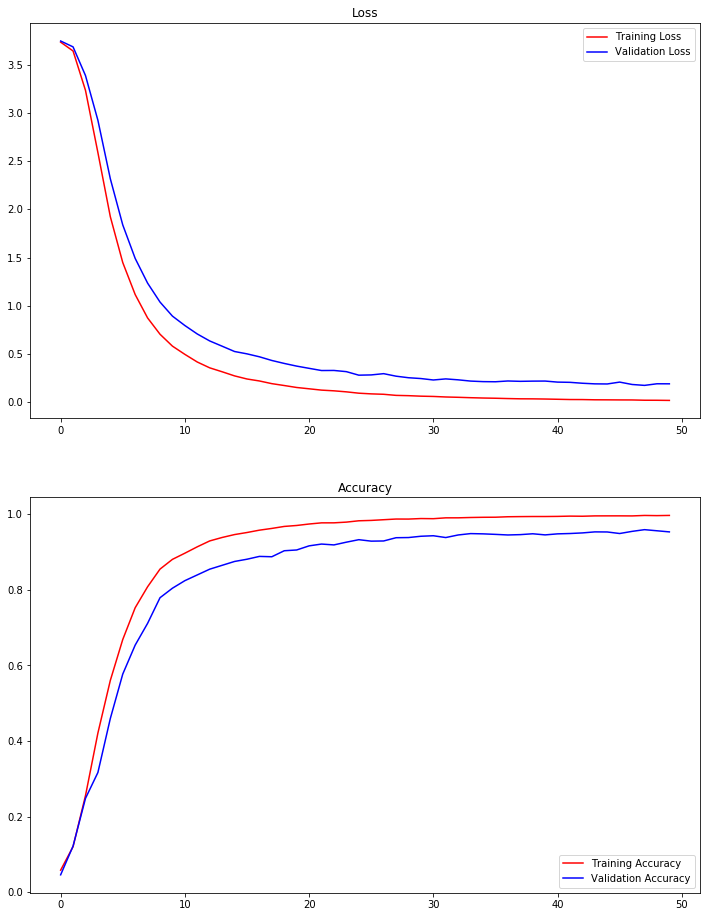

In [16]:
fig = plt.figure(figsize=(12,16))
ax = plt.subplot(2,1,1)
ax.set_title('Loss')
plt.plot(train_loss_history, 'r', label='Training Loss')
plt.plot(valid_loss_history, 'b', label='Validation Loss')
# loss_plot.set_xlim([0, EPOCHS])
plt.legend(loc=1)
ax = plt.subplot(2,1,2)
ax.set_title('Accuracy')
plt.plot(train_acc_history, 'r', label='Training Accuracy')
plt.plot(valid_acc_history, 'b', label='Validation Accuracy')
# loss_plot.set_xlim([0, EPOCHS])
plt.legend(loc=4)
plt.show()

In [17]:
with tf.Session() as sess:
    saver.restore(sess, './gtsrb_lenet')
    test_loss, test_accuracy = evaluate(X_test_new, Y_test_new)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.946


---

## <a id='new_images'>Step 5: Test a Model on New Images</a>

[Google Street View](https://www.google.com/streetview/) is an endless source for getting images of traffic signs.  In this part of the project we are going to test our model on the images found on the streets of suburban area of Hamburg.

### Load and Output the Images

In [51]:
### Load the traffic sign images and plot them here.
from scipy.misc import imread

street_view_img_dir = './img/'
street_view_img_names = [
                        'street_view_1.png',
                        'street_view_2.png',
                        'street_view_3.png',
                        'street_view_4.png',
                        'street_view_5.png',
                        'street_view_6.png',
                        'street_view_7.png',
                        'street_view_8.png',
                        'street_view_9.png',
                        ]
street_view_img = [ imread(street_view_img_dir + img) for img in street_view_img_names ]

#### Traffic sign images in wild:

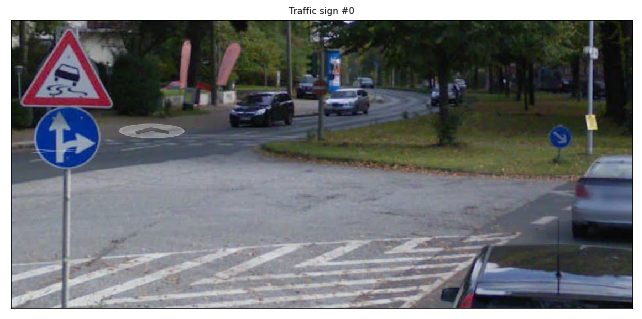

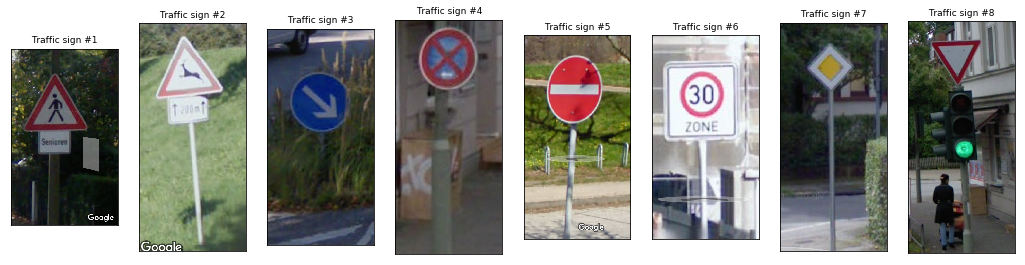

In [55]:
fig = plt.figure(figsize=(8,28))
ax = fig.add_subplot(1,1,1)
plt.imshow(street_view_img[0])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Traffic sign #0', fontsize=9)
plt.tight_layout(w_pad=-0.2, h_pad=-12.2, pad=-2.6)
plt.show()

NUM_IMG = len(street_view_img[1:])
fig = plt.figure(figsize=(18,24))
for idx, image in enumerate(street_view_img[1:]):
    ax = fig.add_subplot(1,NUM_IMG,idx+1)
    plt.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Traffic sign #{}'.format(idx+1), fontsize=9)
plt.show()

The images above from the Google street view are all of different size. We first obtain square images containing traffic signs only. This can be done in various ways, including python's `cv2` module, although in the project I  used GIMP to obtain cropped images. Let's visualize them.

In [56]:
street_view_img_crop_names = [
                        "new_square_img_1.png",
                        "new_square_img_2.png",
                        "new_square_img_3.png",
                        "new_square_img_4.png",
                        "new_square_img_5.png",
                        "new_square_img_6.png",
                        "new_square_img_7.png",
                        "new_square_img_8.png",
                        "new_square_img_9.png",
                        "new_square_img_10.png",
                        ]
street_view_img_crop = [ imread(street_view_img_dir + img) for img in street_view_img_crop_names ]

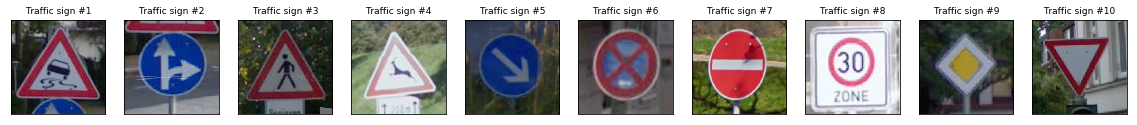

In [61]:
fig = plt.figure(figsize=(20,6))

NUM_IMG = len(street_view_img_crop)
for idx, image in enumerate(street_view_img_crop):
    ax = fig.add_subplot(1,NUM_IMG,idx+1)
    plt.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Traffic sign #{}'.format(idx+1), fontsize=9)
plt.show()

We now resize the images to 32x32 to be able to use them with our CNN classificator

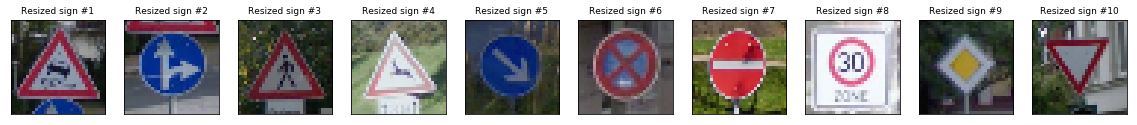

In [63]:
skimage.transform.resize(street_view_img_crop[0], (32, 32), mode='constant').shape
traffic_signs_resized = list(map(lambda x : skimage.transform.resize(x, (32, 32), mode='constant'), 
                                 street_view_img_crop))
fig = plt.figure(figsize=(20,6))

NUM_IMG = len(traffic_signs_resized)
for idx, image in enumerate(traffic_signs_resized):
    ax = fig.add_subplot(1,NUM_IMG,idx+1)
    plt.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Resized sign #{}'.format(idx+1), fontsize=9)
plt.show()

In [64]:
X_new_img = np.array(traffic_signs_resized)
X_new_img = X_new_img - 0.5
print("New traffic signs: {}".format(X_new_img.shape))

New traffic signs: (10, 32, 32, 3)


### Predict the Sign Type for Each Image

In [65]:
### Run the predictions here and use the model to output the prediction for each image.

prediction_result = None
with tf.Session() as sess:
    # Initialize variables
    sess.run(init)
    # Restore model weights from previously saved model
    loader = tf.train.import_meta_graph('./gtsrb_lenet.meta')
    saver.restore(sess, './gtsrb_lenet')
    print("Model gtsrb_lenet restored ")
    prediction_result = sess.run(tf.nn.softmax(logits), feed_dict={x: X_new_img, keep_prob : 1.0})
    print("Done..")
    


Model gtsrb_lenet restored 
(10, 43)


In [66]:
for el in prediction_result:
    print(text_labels[np.argmax(el)])

Slippery road
Go straight or right
Pedestrians
Wild animals crossing
Keep right
Speed limit (80km/h)
No entry
Speed limit (120km/h)
Priority road
Yield


In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

y_new = [
         23, #Slippery road
         36, #Go straight or right
         27, #Pedestrians
         31, #Wild animals crossing
         38, #Keep right
         99, #No such sign
         17, #No entry
         1,  #Speed limit (30km/h)
         12, #Priority road
         13, #Yield
        ]

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.